<a href="https://colab.research.google.com/github/suryanshshah2006/Face-Recognition-Detection/blob/main/face_detection_and_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opencv-python matplotlib

In [ ]:
import cv2
import matplotlib.pyplot as plt
import sys
import os

In [ ]:
CASCADE_FILE = '/content/haarcascade_frontalface_default.xml'
IMAGE_FILE = '/content/WhatsApp Image 2025-11-12 at 23.00.54_2bd83e8f.jpg'

In [ ]:
face_cascade = cv2.CascadeClassifier(CASCADE_FILE)
if face_cascade.empty():
    print(f"Error: Could not load cascade classifier from {CASCADE_FILE}.")
    sys.exit()
print("Cascade model loaded successfully.")

Cascade model loaded successfully.


In [ ]:
img_bgr = cv2.imread(IMAGE_FILE)
if img_bgr is None:
    print(f"Error: Could not load image from {IMAGE_FILE}.")
    sys.exit()

In [ ]:
gray_img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
print("Image loaded and converted to grayscale.")

Image loaded and converted to grayscale.


In [ ]:
faces = face_cascade.detectMultiScale(
    gray_img,
    scaleFactor=1.1,
    minNeighbors=5,
    minSize=(30, 30)
)

In [ ]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
for (x, y, w, h) in faces:
    cv2.rectangle(img_rgb, (x, y), (x+w, y+h), (0, 255, 0), 2)

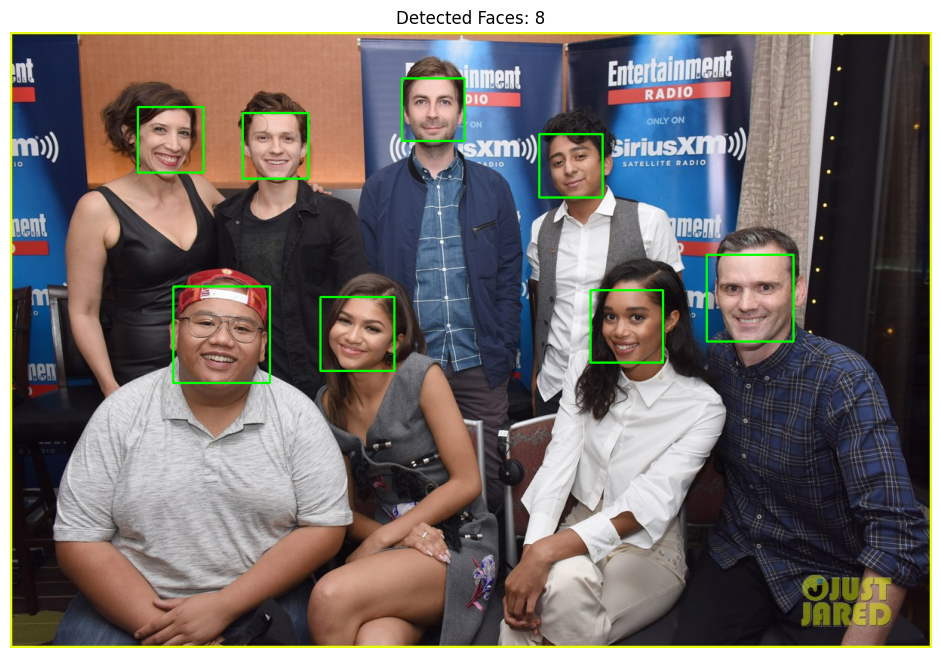

Face detection finished.


In [ ]:
plt.figure(figsize=(12, 8))
plt.imshow(img_rgb)
plt.title(f'Detected Faces: {len(faces)}')
plt.axis('off')
plt.show()
print("Face detection finished.")

In [ ]:
!pip install face_recognition
!pip install numpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.1/100.1 MB 9.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566166 sha256=ce75b6872db98f09618f6b8c61d7e2b5c1f93178161d7c802c39d22c3fb2d0da
  Stored in directory: /root/.cache/pip/wheels/8f/47/c8/f44c5aebb7507f7c8a2c0bd23151d732d0f0bd6884ad4ac635
Successfully built face-recognition-models


In [ ]:
!pip install facenet-pytorch

In [ ]:
import face_recognition
import numpy as np

In [ ]:
import torch
from facenet_pytorch import MTCNN, InceptionResnetV1
from PIL import Image
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("Using device:", device)

Using device: cuda


In [ ]:
mtcnn = MTCNN(keep_all=True, device=device)  # Detect multiple faces
resnet = InceptionResnetV1(pretrained='vggface2').eval().to(device)

  0%|          | 0.00/107M [00:00<?, ?B/s]

In [ ]:
train_image_path = "/content/WhatsApp Image 2025-11-12 at 23.00.54_2bd83e8f.jpg"
train_image = Image.open(train_image_path)

In [ ]:
faces_tensors, probs = mtcnn(train_image, return_prob=True)  # faces_tensors shape: [num_faces, 3, 160, 160]

In [ ]:
faces_tensors = [f.unsqueeze(0).to(device) for f, p in zip(faces_tensors, probs) if p > 0.90]

In [ ]:
train_embeddings = [resnet(f).detach() for f in faces_tensors]
train_embeddings = torch.cat(train_embeddings)
print(f"Detected and encoded {len(train_embeddings)} faces in training image.")

Detected and encoded 8 faces in training image.


In [ ]:
test_image_path = "/content/Spider-Man-4-gets-massive-Zendaya-Tom-Holland-updates.webp"
test_image = Image.open(test_image_path)

In [ ]:
test_faces_tensors, probs = mtcnn(test_image, return_prob=True)

In [ ]:
test_faces_tensors = [f.unsqueeze(0).to(device) for f, p in zip(test_faces_tensors, probs) if p > 0.90]

In [ ]:
for test_tensor in test_faces_tensors:
    test_emb = resnet(test_tensor).detach()
    distances = [(torch.norm(test_emb - emb).item()) for emb in train_embeddings]
    min_distance = min(distances)
    matched_idx = distances.index(min_distance)
    print(f"Closest match is training face #{matched_idx} with distance {min_distance:.4f}")
    if min_distance < 1.0:
        print("Face recognized!")
    else:
        print("Face not recognized.")





Closest match is training face #4 with distance 0.8209
Face recognized!
Closest match is training face #3 with distance 0.7431
Face recognized!
Closest match is training face #0 with distance 1.0907
Face not recognized.


In [ ]:
from PIL import ImageDraw
from IPython.display import display

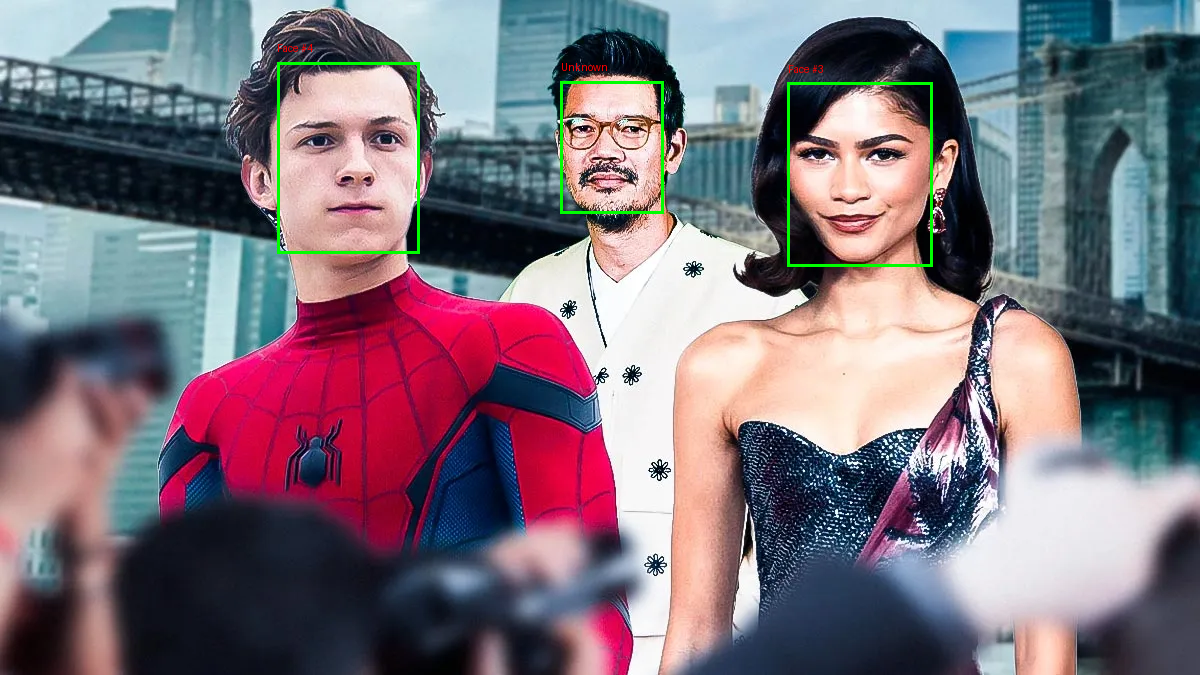

In [ ]:
draw_image = test_image.copy()
draw = ImageDraw.Draw(draw_image)
for i, test_tensor in enumerate(test_faces_tensors):
    test_emb = resnet(test_tensor).detach()
    distances = [(torch.norm(test_emb - emb).item()) for emb in train_embeddings]
    min_distance = min(distances)
    matched_idx = distances.index(min_distance)
    box = mtcnn.detect(test_image)[0][i]  # returns [x1, y1, x2, y2]
    if min_distance < 1.0:
        label = f"Face #{matched_idx}"
    else:
        label = "Unknown"
    draw.rectangle(box.tolist(), outline=(0, 255, 0), width=3)
    draw.text((box[0], box[1]-20), label, fill=(255, 0, 0))
display(draw_image)